InstaDeep ML test <br>
Author: Mously Diaw

# Protein sequence classification

Proteins are sequence of amino acids, which can be encoded by a single letter. This project aims at building a deep learning model that assigns amino acid sequences to their protein family. The [Pfam dataset](https://www.kaggle.com/googleai/pfam-seed-random-split) is used for this task. 

1. [Dataset analysis](#section-one) <br>
2. [Classifier](#section-two) <br>
3. [Conclusion](#section-three) <br>

In [1]:
#Import packages
%matplotlib inline
import os
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
#import re 
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical 
from keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder 
from keras.models import Sequential
from keras.layers import Flatten, Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Bidirectional

<a id="section-one"></a>
# 1. Dataset analysis 

## 1.1. Loading the data

In [2]:
def load_data(partition,col_list):
    data = []
    for fn in os.listdir(os.path.join(data_path, partition)):
        with open(os.path.join(data_path, partition, fn)) as f:
            data.append(pd.read_csv(f, index_col=None,usecols=col_list))
    return pd.concat(data) 

We wish to predict *family_accession* given *sequence* so we will focus on these two attributes.

In [3]:
data_path = '../input/pfam-seed-random-split/random_split/random_split/'
col_list = ["family_accession","sequence"]
df_train = load_data('train',col_list)
df_val = load_data('dev',col_list)
df_test = load_data('test',col_list)

In [4]:
print('Data size:')
print('Train size :', len(df_train))
print('Val size :', len(df_val))
print('Test size :', len(df_test))

Data size:
Train size : 1086741
Val size : 126171
Test size : 126171


In [5]:
df_train.head()

,family_accession,sequence
0,PF08891.11,IEFEEKMLELIDARIESASDDELFAGGYLRGHISLSVANCEEQGIN...
1,PF01033.17,TTCAVRGCSDINLNQNCQCDPSCYSFGDCCADFAAVCESS
2,PF01805.20,RNIIDKLAQFVARNGPEFEQMTKNKQKDNPKFSFLFGGEYFNYYQYKVT
3,PF06799.11,AVPREQRPVNELQQLKDTPLLAWATLDLPQYAQRLLILYGGVFLLL...
4,PF15494.6,GPNFILEVYSPVSQTWYPVCQDDWTDDFGKIACEDMGYNVDTYYYS...


## 1.2. Exploratory data analysis (EDA) and data pre-processing

### 1.2.1. Preliminary processing and EDA

Let's first merge the data.

In [6]:
frames = [df_train, df_val, df_test]
df_full = pd.concat(frames)

In [7]:
print('Total number of unique protein families:',len(df_full.family_accession.unique()))

Total number of unique protein families: 17929


Since the data set has over a million samples, we will first work with a sample of it.  

In [8]:
n_samples = 12000
df_partial = df_full.sample(n = n_samples, random_state=1)
num_classes = len(df_partial.family_accession.unique())
print('Number of unique protein families in the small training set:',num_classes)

Number of unique protein families in the small training set: 5770


We will now compute the number of occurences of each amino acid and the length of the sequences in the training set.

In [9]:
# Count frequency amino acids
keys = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L','M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y','X', 'U', 'B', 'O', 'Z']

d = {key: 0 for key in keys}
for sequence in df_partial.sequence:     
    for char in sequence: 
        d[char] = d[char] + 1 

# Order by frequency 
d_sorted = sorted(((d[key],key) for key in d), reverse =True) 

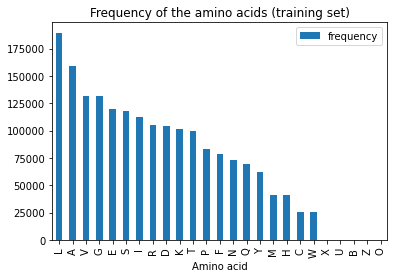

In [10]:
df_freq = pd.DataFrame(d_sorted, columns=['frequency', 'Amino acid'])
df_freq.plot(kind='bar', x='Amino acid')
plt.title("Frequency of the amino acids (training set)")
plt.show() 

We can see that there are 20 common amino acids. X,U,Z,B,O are the least frequent. 

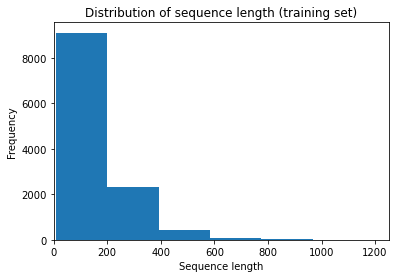

In [11]:
sequence_length = [len(sequence) for sequence in df_partial.sequence]
plt.hist(sequence_length)
plt.xlabel('Sequence length')
plt.ylabel('Frequency')
plt.title('Distribution of sequence length (training set)') 
plt.xlim(0, 1250) 
plt.show()

The figure above shows that most of the sequences have less than 200 amino acids.  

### 1.2.2. Sequence processing 

Before feeding the data to a neural network, the sequences must be converted into tensors. We chose to tokenize the sequences by breaking them into characters. We then vectorize them (convert each character to a number) using a dictionary with the 20 most common amino acids; the 5 least frequent ones are affected the value '21'. After vectorization, we bring all sequences to the same length before one-hot encoding them. 

In [12]:
amino_acids = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L','M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']

def create_dict(codes):
    char_dict = {}
    for index, val in enumerate(codes):
        char_dict[val] = index+1
    return char_dict

char_dict = create_dict(amino_acids)

print("Dictionary:", char_dict)

Dictionary: {'A': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'Y': 20}


In [13]:
def vectorized_sequence(sequence):
    """
    Encodes the sequence using predefined dictionary. The 5 least frequent amino acids are affected the value '21'
    """
    code = []
    l = [char for char in sequence]
    for char in l:
        code.append(char_dict.get(char, 21))    
    return code   

Let's illustrate the process with the following sequence

In [14]:
idx=90
print("Amino acid sequence:",df_partial.sequence.iloc[idx])

Amino acid sequence: SLCNQLQCAAGKWFHEHSKDNGGSNKKTWCEFWEKEGVKPKLQDLFEKIKSGGQDTNDVCNKFGDENPDSVERKACNHITAGLQHIKDIPPSGSGNGVVQSKDQDNQLLQRAVGCIALNMYADQIIAKSKDSCPIDESKIQDMFTKWNEKYNNNSSSSPSCNDVNNKDCFVCKRVQKSELNNCQL


In [15]:
vectorized_sequences = [vectorized_sequence(sequence) for sequence in df_partial.sequence]  

In [16]:
print("Vectorized sequence:", vectorized_sequences[idx])

Vectorized sequence: [16, 10, 2, 12, 14, 10, 14, 2, 1, 1, 6, 9, 19, 5, 7, 4, 7, 16, 9, 3, 12, 6, 6, 16, 12, 9, 9, 17, 19, 2, 4, 5, 19, 4, 9, 4, 6, 18, 9, 13, 9, 10, 14, 3, 10, 5, 4, 9, 8, 9, 16, 6, 6, 14, 3, 17, 12, 3, 18, 2, 12, 9, 5, 6, 3, 4, 12, 13, 3, 16, 18, 4, 15, 9, 1, 2, 12, 7, 8, 17, 1, 6, 10, 14, 7, 8, 9, 3, 8, 13, 13, 16, 6, 16, 6, 12, 6, 18, 18, 14, 16, 9, 3, 14, 3, 12, 14, 10, 10, 14, 15, 1, 18, 6, 2, 8, 1, 10, 12, 11, 20, 1, 3, 14, 8, 8, 1, 9, 16, 9, 3, 16, 2, 13, 8, 3, 4, 16, 9, 8, 14, 3, 11, 5, 17, 9, 19, 12, 4, 9, 20, 12, 12, 12, 16, 16, 16, 16, 13, 16, 2, 12, 3, 18, 12, 12, 9, 3, 2, 5, 18, 2, 9, 15, 18, 14, 9, 16, 4, 10, 12, 12, 2, 14, 10]


In [17]:
maxlen = 200
padded_sequences = pad_sequences(vectorized_sequences , maxlen=maxlen, padding='post')

In [18]:
print("Padded sequence:", padded_sequences[idx])

Padded sequence: [16 10  2 12 14 10 14  2  1  1  6  9 19  5  7  4  7 16  9  3 12  6  6 16
 12  9  9 17 19  2  4  5 19  4  9  4  6 18  9 13  9 10 14  3 10  5  4  9
  8  9 16  6  6 14  3 17 12  3 18  2 12  9  5  6  3  4 12 13  3 16 18  4
 15  9  1  2 12  7  8 17  1  6 10 14  7  8  9  3  8 13 13 16  6 16  6 12
  6 18 18 14 16  9  3 14  3 12 14 10 10 14 15  1 18  6  2  8  1 10 12 11
 20  1  3 14  8  8  1  9 16  9  3 16  2 13  8  3  4 16  9  8 14  3 11  5
 17  9 19 12  4  9 20 12 12 12 16 16 16 16 13 16  2 12  3 18 12 12  9  3
  2  5 18  2  9 15 18 14  9 16  4 10 12 12  2 14 10  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0]


In [19]:
oh_sequences = to_categorical(padded_sequences)

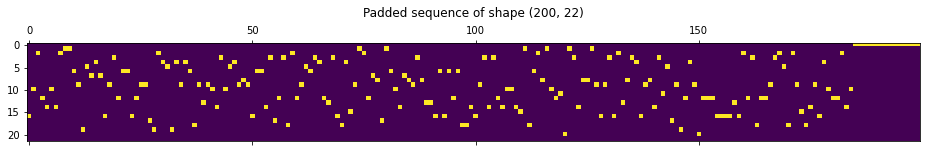

In [20]:
seq = oh_sequences[idx]
plt.matshow(seq.transpose())
plt.title("Padded sequence of shape %s" % (seq.shape,) + "\n")
plt.show()

Finally we will transform the labels by integer encoding. 

In [21]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_partial.family_accession) 

We will split the sampled data into the training, validation and test sets.

In [22]:
X = padded_sequences
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [23]:
print("Length train set:",len(X_train))
print("Length val set:",len(X_val))
print("Length test set:",len(X_test))

Length train set: 9720
Length val set: 1080
Length test set: 1200


<a id="section-two"></a>
# 2. Classifier 

Let's first build a baseline model.

To train the model, we will load the data in batches by creating a data iterator. 

In [24]:
class DataIterator:
    """ Collects data and yields bunch of batches of data
    Takes data sources and batch_size as arguments """
    def _init_(self, data1,data2, batch_size,iters):
        self.data1 = data1
        self.data2 = data2
        self.batch_size = batch_size
        self.iter = iters
        
    def next_batch(self):
        try:
            idxs = next(self.iter)
        except StopIteration:
            self.iter = self.make_random_iter()
            idxs = next(self.iter)
        X =[self.data1[i] for i in idxs]
        Y =[self.data2[i] for i in idxs]
        X = np.array(X)
        Y = np.array(Y)
        return X, Y
    
    def make_random_iter(self):
        splits = np.arange(self.batch_size, len(self.data1),self.batch_size)
        it = np.split(np.random.permutation(range(len(self.data1))), splits)[:-1]
        return iter(it)

In [28]:
def train_val_model(model,epochs,X_train,y_train,batch_size,X_val,y_val):
    train_iter = DataIterator() 
    train_iter.data1 = X_train
    train_iter.data2 = y_train
    train_iter.batch_size = batch_size
    train_iter.iter = train_iter.make_random_iter()
    training_iters = np.ceil(len(y_train)/train_iter.batch_size)
    acc_epochs =[]
    loss_epochs = []
    val_acc_epochs =[]
    val_loss_epochs = []
    for epoch in range(epochs):  
        print("\n" + "Epoch:",epoch)
        step = 0
        acc = 0
        loss = 0
        val_acc = 0
        val_loss = 0
        while  step  <= training_iters:
            batch_x, batch_y = train_iter.next_batch()
            history = model.fit(batch_x, batch_y , epochs=1,batch_size= train_iter.batch_size, 
                            validation_data=(X_val, y_val),verbose = False) 
            acc += history.history['accuracy'][0] 
            loss += history.history['loss'][0]
            val_acc += history.history['val_accuracy'][0]
            val_loss += history.history['val_loss'][0]
            step += 1
            #if step % 50 == 0:
            print(
                    "Training loss (for one batch) at step %d: %.4f"
                    % (step, history.history['loss'][0])
                )
            print("Seen so far: %s samples" % ((step) * train_iter.batch_size))
        acc_epochs.append(acc/training_iters) 
        loss_epochs.append(loss/training_iters) 
        val_acc_epochs.append(val_acc/training_iters)
        val_loss_epochs.append(val_loss/training_iters)
    return [acc_epochs,loss_epochs,val_acc_epochs,val_loss_epochs]

In [ ]:
model1 = Sequential([
    Embedding(22, 8, input_length=maxlen),  
    Flatten(),   
    Dense(num_classes, activation ='softmax') 
]) 

model1.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model1.summary()

In [ ]:
epochs = 12
batch_size = 64
acc_loss = train_val_model(model1,epochs,X_train,y_train,batch_size,X_val,y_val)

In [ ]:
epochs = range(1, len(acc_loss) + 1) 
plt.plot(acc_loss[0], 'bo', label='Training acc') 
plt.plot(acc_loss[2], 'r', label='Validation acc') 
plt.legend() 
plt.figure() 
plt.plot(acc_loss[1], 'bo', label='Training loss')  
plt.plot(acc_loss[3], 'r', label='Validation loss')
plt.legend() 
plt.show() 

In [ ]:
results = model1.evaluate(X_test, y_test)
print("test loss, test acc:", results)

In [ ]:
model2 = Sequential([
    Embedding(22, 8, input_length=maxlen), 
    Flatten(),
    Dense(num_classes, activation ='softmax') 
]) 

model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model2.summary()


In [ ]:
epochs = 15
batch_size = 512
acc_loss = train_val_model(model2,epochs,X_train,y_train,batch_size,X_val,y_val)

In [ ]:
epochs = range(1, len(acc_loss) + 1) 
plt.plot(acc_loss[0], 'bo', label='Training acc') 
plt.plot(acc_loss[2], 'r', label='Validation acc') 
plt.legend() 
plt.figure() 
plt.plot(acc_loss[1], 'bo', label='Training loss')  
plt.plot(acc_loss[3], 'r', label='Validation loss')
plt.legend() 
plt.show() 

In [ ]:
results = model2.evaluate(X_test, y_test)
print("test loss, test acc:", results)

In [26]:
model8 = Sequential([
    Embedding(22, 8, input_length=maxlen),
    Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.5)),
    Conv1D(filters=100, kernel_size=5, padding='same', activation='relu') , 
    MaxPooling1D(pool_size=2),
    
    Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.5)),
    Conv1D(filters=100, kernel_size=5, padding='same', activation='relu'),   
    MaxPooling1D(pool_size=2),
    
    Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.5)),
    Conv1D(filters=100, kernel_size=5, padding='same', activation='relu') ,  
    MaxPooling1D(pool_size=2),
    
    Bidirectional(LSTM(100, return_sequences=True, recurrent_dropout=0.5)),
    Conv1D(filters=100, kernel_size=5, padding='same', activation='relu') ,  
    MaxPooling1D(pool_size=2),
    Bidirectional(LSTM(100, return_sequences=False, recurrent_dropout=0.5)),
    
    Dense(num_classes, activation ='softmax') 
]) 

model8.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model8.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 8)            176       
_________________________________________________________________
bidirectional (Bidirectional (None, 200, 200)          87200     
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 100)          100100    
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 100, 100)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100, 200)          160800    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 100, 100)          100100    
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 100)           0

In [29]:
epochs = 5
batch_size = 64
acc_loss = train_val_model(model8,epochs,X_train,y_train,batch_size,X_val,y_val)


Epoch: 0
Training loss (for one batch) at step 1: 8.6493
Seen so far: 64 samples
Training loss (for one batch) at step 2: 8.6430
Seen so far: 128 samples
Training loss (for one batch) at step 3: 8.6344
Seen so far: 192 samples
Training loss (for one batch) at step 4: 8.5466
Seen so far: 256 samples
Training loss (for one batch) at step 5: 8.5754
Seen so far: 320 samples
Training loss (for one batch) at step 6: 8.5217
Seen so far: 384 samples
Training loss (for one batch) at step 7: 8.5415
Seen so far: 448 samples
Training loss (for one batch) at step 8: 8.4776
Seen so far: 512 samples
Training loss (for one batch) at step 9: 8.6263
Seen so far: 576 samples
Training loss (for one batch) at step 10: 8.6761
Seen so far: 640 samples
Training loss (for one batch) at step 11: 8.5326
Seen so far: 704 samples
Training loss (for one batch) at step 12: 8.6338
Seen so far: 768 samples
Training loss (for one batch) at step 13: 8.6376
Seen so far: 832 samples
Training loss (for one batch) at step 

Training loss (for one batch) at step 111: 8.6514
Seen so far: 7104 samples
Training loss (for one batch) at step 112: 8.7290
Seen so far: 7168 samples
Training loss (for one batch) at step 113: 8.6727
Seen so far: 7232 samples
Training loss (for one batch) at step 114: 8.5822
Seen so far: 7296 samples
Training loss (for one batch) at step 115: 8.6393
Seen so far: 7360 samples
Training loss (for one batch) at step 116: 8.6088
Seen so far: 7424 samples
Training loss (for one batch) at step 117: 8.6448
Seen so far: 7488 samples
Training loss (for one batch) at step 118: 8.6608
Seen so far: 7552 samples
Training loss (for one batch) at step 119: 8.6230
Seen so far: 7616 samples
Training loss (for one batch) at step 120: 8.6913
Seen so far: 7680 samples
Training loss (for one batch) at step 121: 8.6251
Seen so far: 7744 samples
Training loss (for one batch) at step 122: 8.6104
Seen so far: 7808 samples
Training loss (for one batch) at step 123: 8.6508
Seen so far: 7872 samples
Training los

Training loss (for one batch) at step 67: 8.4465
Seen so far: 4288 samples
Training loss (for one batch) at step 68: 8.5698
Seen so far: 4352 samples
Training loss (for one batch) at step 69: 8.2513
Seen so far: 4416 samples
Training loss (for one batch) at step 70: 8.4537
Seen so far: 4480 samples
Training loss (for one batch) at step 71: 8.4345
Seen so far: 4544 samples
Training loss (for one batch) at step 72: 8.5276
Seen so far: 4608 samples
Training loss (for one batch) at step 73: 8.6159
Seen so far: 4672 samples
Training loss (for one batch) at step 74: 8.4738
Seen so far: 4736 samples
Training loss (for one batch) at step 75: 8.5570
Seen so far: 4800 samples
Training loss (for one batch) at step 76: 8.4660
Seen so far: 4864 samples
Training loss (for one batch) at step 77: 8.5815
Seen so far: 4928 samples
Training loss (for one batch) at step 78: 8.4032
Seen so far: 4992 samples
Training loss (for one batch) at step 79: 8.4266
Seen so far: 5056 samples
Training loss (for one ba

Training loss (for one batch) at step 23: 8.4611
Seen so far: 1472 samples
Training loss (for one batch) at step 24: 8.2962
Seen so far: 1536 samples
Training loss (for one batch) at step 25: 8.3937
Seen so far: 1600 samples
Training loss (for one batch) at step 26: 8.3171
Seen so far: 1664 samples
Training loss (for one batch) at step 27: 8.2541
Seen so far: 1728 samples
Training loss (for one batch) at step 28: 8.3566
Seen so far: 1792 samples
Training loss (for one batch) at step 29: 8.2630
Seen so far: 1856 samples
Training loss (for one batch) at step 30: 8.3742
Seen so far: 1920 samples
Training loss (for one batch) at step 31: 8.2085
Seen so far: 1984 samples
Training loss (for one batch) at step 32: 8.4057
Seen so far: 2048 samples
Training loss (for one batch) at step 33: 8.2180
Seen so far: 2112 samples
Training loss (for one batch) at step 34: 8.2622
Seen so far: 2176 samples
Training loss (for one batch) at step 35: 8.5196
Seen so far: 2240 samples
Training loss (for one ba

Training loss (for one batch) at step 132: 8.4452
Seen so far: 8448 samples
Training loss (for one batch) at step 133: 8.3691
Seen so far: 8512 samples
Training loss (for one batch) at step 134: 8.4781
Seen so far: 8576 samples
Training loss (for one batch) at step 135: 8.3620
Seen so far: 8640 samples
Training loss (for one batch) at step 136: 8.3457
Seen so far: 8704 samples
Training loss (for one batch) at step 137: 8.4772
Seen so far: 8768 samples
Training loss (for one batch) at step 138: 8.3663
Seen so far: 8832 samples
Training loss (for one batch) at step 139: 8.2538
Seen so far: 8896 samples
Training loss (for one batch) at step 140: 8.3502
Seen so far: 8960 samples
Training loss (for one batch) at step 141: 8.3484
Seen so far: 9024 samples
Training loss (for one batch) at step 142: 8.4578
Seen so far: 9088 samples
Training loss (for one batch) at step 143: 8.2850
Seen so far: 9152 samples
Training loss (for one batch) at step 144: 8.1651
Seen so far: 9216 samples
Training los

Training loss (for one batch) at step 89: 8.2198
Seen so far: 5696 samples
Training loss (for one batch) at step 90: 8.3300
Seen so far: 5760 samples
Training loss (for one batch) at step 91: 8.5198
Seen so far: 5824 samples
Training loss (for one batch) at step 92: 8.4234
Seen so far: 5888 samples
Training loss (for one batch) at step 93: 8.3705
Seen so far: 5952 samples
Training loss (for one batch) at step 94: 8.2913
Seen so far: 6016 samples
Training loss (for one batch) at step 95: 8.4138
Seen so far: 6080 samples
Training loss (for one batch) at step 96: 8.3103
Seen so far: 6144 samples
Training loss (for one batch) at step 97: 8.3919
Seen so far: 6208 samples
Training loss (for one batch) at step 98: 8.3477
Seen so far: 6272 samples
Training loss (for one batch) at step 99: 8.2283
Seen so far: 6336 samples
Training loss (for one batch) at step 100: 8.3095
Seen so far: 6400 samples
Training loss (for one batch) at step 101: 8.3521
Seen so far: 6464 samples
Training loss (for one 

Training loss (for one batch) at step 45: 8.2456
Seen so far: 2880 samples
Training loss (for one batch) at step 46: 8.4196
Seen so far: 2944 samples
Training loss (for one batch) at step 47: 8.1854
Seen so far: 3008 samples
Training loss (for one batch) at step 48: 8.3470
Seen so far: 3072 samples
Training loss (for one batch) at step 49: 8.1608
Seen so far: 3136 samples
Training loss (for one batch) at step 50: 8.3810
Seen so far: 3200 samples
Training loss (for one batch) at step 51: 8.3119
Seen so far: 3264 samples
Training loss (for one batch) at step 52: 8.4359
Seen so far: 3328 samples
Training loss (for one batch) at step 53: 8.2972
Seen so far: 3392 samples
Training loss (for one batch) at step 54: 8.3620
Seen so far: 3456 samples
Training loss (for one batch) at step 55: 8.3856
Seen so far: 3520 samples
Training loss (for one batch) at step 56: 8.1973
Seen so far: 3584 samples
Training loss (for one batch) at step 57: 8.3547
Seen so far: 3648 samples
Training loss (for one ba

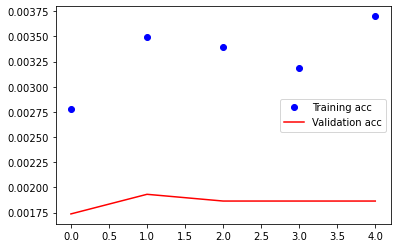

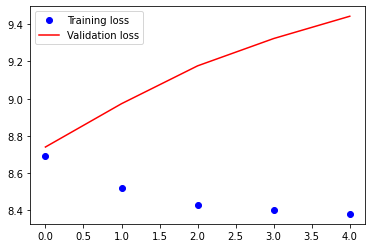

In [30]:
epochs = range(1, len(acc_loss) + 1) 
plt.plot(acc_loss[0], 'bo', label='Training acc') 
plt.plot(acc_loss[2], 'r', label='Validation acc') 
plt.legend() 
plt.figure() 
plt.plot(acc_loss[1], 'bo', label='Training loss')  
plt.plot(acc_loss[3], 'r', label='Validation loss')
plt.legend() 
plt.show()

In [ ]:
results = model8.evaluate(X_test, y_test)
print("test loss, test acc:", results)

Increase data size

In [ ]:
n_samples = 25000
df_partial = df_full.sample(n = n_samples, random_state=1)  
num_classes = len(df_partial.family_accession.unique())

In [ ]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df_partial.family_accession) 

In [ ]:
vectorized_sequences = [vectorized_sequence(sequence) for sequence in df_partial.sequence] 
maxlen = 200
padded_sequences = pad_sequences(vectorized_sequences , maxlen=maxlen, padding='post')

X = padded_sequences
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

In [ ]:
model3 = Sequential([
    Embedding(22, 8, input_length=maxlen),  
    #Conv1D(64, 3, activation='relu'),
    Flatten(),   
    Dense(num_classes, activation ='softmax') 
]) 

model3.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model3.summary()

In [ ]:
epochs = 5
batch_size = 64
acc_loss = train_val_model(model3,epochs,X_train,y_train,batch_size,X_val,y_val)

In [ ]:
epochs = range(1, len(acc_loss) + 1) 
plt.plot(acc_loss[0], 'bo', label='Training acc') 
plt.plot(acc_loss[2], 'r', label='Validation acc') 
plt.legend() 
plt.figure() 
plt.plot(acc_loss[1], 'bo', label='Training loss')  
plt.plot(acc_loss[3], 'r', label='Validation loss')
plt.legend() 
plt.show() 

In [ ]:
results = model3.evaluate(X_test, y_test)
print("test loss, test acc:", results)

<a id="section-three"></a>
# Conclusion
**^html link hidden here, fork notebook then click this cell to see it**

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Sed velit dignissim sodales ut eu sem integer vitae. Quam vulputate dignissim suspendisse in est ante. Arcu non odio euismod lacinia at. Etiam tempor orci eu lobortis. Egestas sed sed risus pretium quam vulputate dignissim suspendisse. Magna eget est lorem ipsum dolor sit amet consectetur adipiscing. Eget velit aliquet sagittis id consectetur purus ut faucibus. Egestas quis ipsum suspendisse ultrices gravida dictum fusce ut. Sed pulvinar proin gravida hendrerit. Dui faucibus in ornare quam viverra. Elit ullamcorper dignissim cras tincidunt lobortis feugiat vivamus. Enim diam vulputate ut pharetra sit amet aliquam. Nec feugiat in fermentum posuere urna nec tincidunt praesent. Elementum nisi quis eleifend quam adipiscing vitae proin sagittis. Malesuada proin libero nunc consequat interdum varius sit amet mattis. Urna neque viverra justo nec ultrices dui sapien. Adipiscing tristique risus nec feugiat in. Habitant morbi tristique senectus et netus et malesuada.